1\. **Color-coded scatter plot**

Produce a scatter plot from a dataset with two categories.

* Write a function that generates a 2D datasets of 2 categories. Each category should distribute as a 2D gaussian with a given mean and standard deviation. Set different values of the mean and stardand deviation between the two samples.
* Display the dataset in a scatter plot marking the two categories with different marker colors.

An example is given below:

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

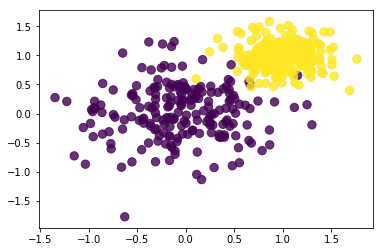

In [2]:
from IPython.display import Image
Image('data/two_categories_scatter_plot.png')

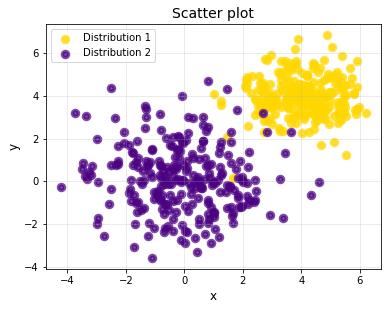

In [5]:
#exercise n.1

def gauss_2d(N,mean1,mean2,std_dev1,std_dev2): #N will be the total number of entries for each hisotgram
    global x
    global y
    x=np.random.normal(loc=mean1, scale=std_dev1, size=(N,2))
    y=np.random.normal(loc=mean2, scale=std_dev2, size=(N,2))
    return x,y

x,y=gauss_2d(250,4.,0.,1.,1.5)
fig, ax = plt.subplots(figsize=(6, 4.5))
ax.scatter(x[:,0],x[:,1], marker='o', c='gold', alpha=0.7, linewidths=3.5, label='Distribution 1')
ax.scatter(y[:,0],y[:,1], marker='o', c='indigo', alpha=0.7, linewidths=3.5, label='Distribution 2')
ax.set_title('Scatter plot',  fontsize=14)
ax.set_xlabel('x', fontsize=12)
ax.set_ylabel('y', fontsize=12)
ax.legend()
ax.grid(alpha=0.3)

2\. **Profile plot**

Produce a profile plot from a scatter plot.
* Download the following pickle file:
```bash
wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P data/
```
* Inspect the dataset, you'll find two variables (features)
* Convert the content to a Pandas Dataframe
* Clean the sample by selecting the entries (rows) with the absolute values of the variable "residual" smaller than 2
* Plot a Seaborn jointplot of "residuals" versus "distances", and use seaborn to display a linear regression. 

Comment on the correlation between these variables.

* Create manually (without using seaborn) the profile histogram for the "distance" variable; choose an appropriate binning.
* Obtain 3 numpy arrays:
  * `x`, the array of bin centers of the profile histogram of the "distance" variable
  * `y`, the mean values of the "residuals", estimated in slices (bins) of "distance"
  * `err_y`, the standard deviation of the of the "residuals", estimated in slices (bins) of "distance"
* Plot the profile plot on top of the scatter plot

In [ ]:
!wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P data/

Content of pickle file: 

{'residuals': array([ 1.1       , -1.95      , -7.2       , ...,  0.08333333,
        0.16666667,  0.08333333]), 'distances': array([16. ,  6.3,  3.4, ...,  1.7, 19.1,  2.6])} 







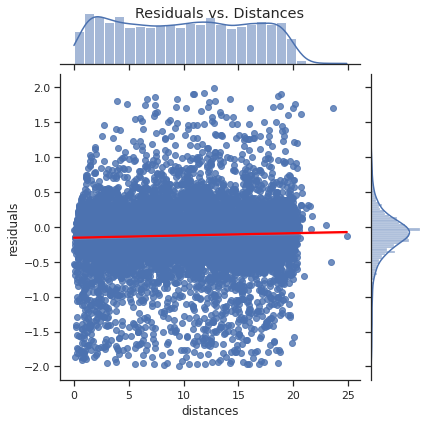

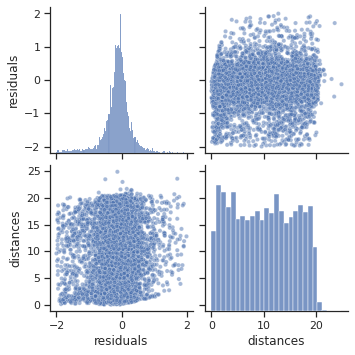

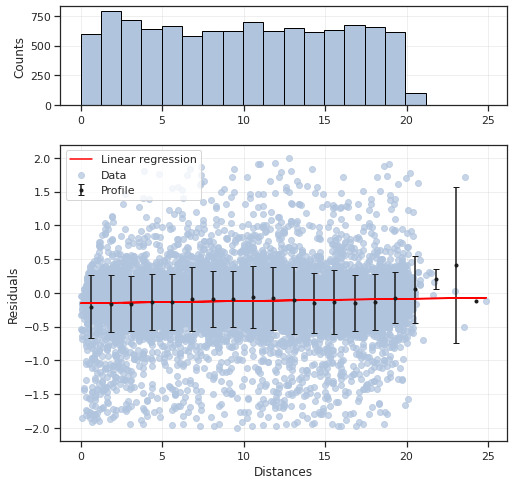

In [7]:
#exercise n.2

import pickle
from matplotlib import gridspec
from scipy.stats import linregress

#Getting the data and displaying a seaborn joinplot for residuals vs distances (including linear regression)
print('Content of pickle file: \n')
infile=open('data/residuals_261.pkl', 'rb')
new_dict=pickle.load(infile)
infile.close()

print(new_dict, '\n')
dictionary=dict(new_dict.item())
df=pd.DataFrame(dictionary)

df=df[abs(df['residuals'])<2.]#only |residuals|<2 considered

sns.set_theme(style='ticks')
p=sns.jointplot(x='distances', y='residuals', data=df,  kind='reg', joint_kws={'line_kws':{'color':'red'}})
p.fig.suptitle('Residuals vs. Distances')
print('\n')


#correlations
sns.pairplot(df, plot_kws={'alpha':0.5, 'size':0.5})
#The data follow a linear trend (even though it's necessary to remember that residuals valuse too high have been
#removed). Nevertheless the correlation plot doesn't seem to show a present correlation between the two variables.



#Building the distances' profile histogram
fig=plt.figure(figsize=(8,8))
#set height ratios for subplots
gs=gridspec.GridSpec(2, 1, height_ratios=[1,3]) 
ax0 = plt.subplot(gs[0])
histo=df.loc[:,'distances']
h, bins, _=ax0.hist(histo, bins=20, color='lightsteelblue', edgecolor='black', density=False, cumulative=False)
ax0.set_ylabel('Counts', fontsize=12)
ax0.grid(alpha=0.3)
print('\n')

#Adding a scatter plot manually created WITHOUT USING SEABORN
ax1=plt.subplot(gs[1], sharex = ax0)
ax1.scatter(x='distances', y='residuals', data=df, marker='o', color='lightsteelblue', alpha=0.7, label='Data')
ax1.set_xlabel('Distances', fontsize=12)
ax1.set_ylabel('Residuals', fontsize=12)
ax1.grid(alpha=0.3)
#linear regression
m, q, rvalue, pvalue, err=linregress(df.distances, df.residuals)
ax1.plot(df.distances, q+m*df.distances, color='red', label='Linear regression')

#Getting the arrays
x=(bins[1:]+bins[:-1])/2

df['dist_sliced']=np.digitize(df['distances'], bins=bins)
y=df.groupby('dist_sliced')['residuals'].mean()

err_y=df.groupby('dist_sliced')['residuals'].std()

ax1.errorbar(x, y, yerr=err_y, fmt='.k', elinewidth=1.5 ,capsize=3, label='Profile')
ax1.legend(loc = "upper left");

3\. **Kernel Density Estimate**

Produce a KDE for a given distribution (by hand, not using seaborn):

* Fill a numpy array `x` of length N (with $N=\mathcal{O}(100)$) with a variable normally distributed, with a given mean and standard deviation
* Fill an histogram in pyplot taking proper care of the aesthetic:
   * use a meaningful number of bins
   * set a proper y axis label
   * set proper value of y axis major ticks labels (e.g. you want to display only integer labels)
   * display the histograms as data points with errors (the error being the poisson uncertainty)
* For every element of `x`, create a gaussian with the mean corresponding to the element value and the standard deviation as a parameter that can be tuned. The standard deviation default value should be:
$$ 1.06 * x.std() * x.size ^{-\frac{1}{5}} $$
you can use the scipy function `stats.norm()` for that.
* In a separate plot (to be placed beside the original histogram), plot all the gaussian functions so obtained
* Sum (with `np.sum()`) all the gaussian functions and normalize the result such that the integral matches the integral of the original histogram. For that you could use the `scipy.integrate.trapz()` method. Superimpose the normalized sum of all gaussians to the first histogram.


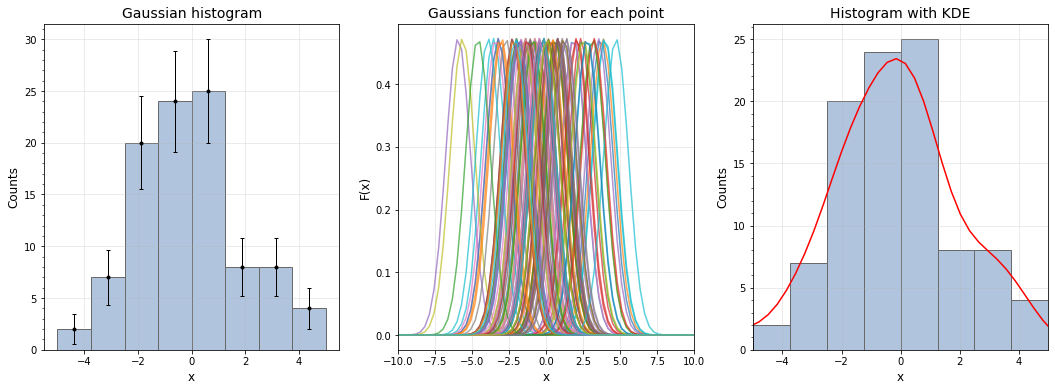

In [9]:
#exercise n.3
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from scipy.stats import norm
from scipy.integrate import trapz

mean, sigma, N=0., 2., 100
x=np.random.normal(loc=mean, scale=sigma, size=(N,))
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
h, bins, _ = ax1.hist(x, bins=8, range=(-5, +5), density=False, cumulative=False, color='lightsteelblue', edgecolor='dimgray')
ax1.set_xlabel('x', fontsize=12)
ax1.set_ylabel('Counts', fontsize=12)
ax1.set_title('Gaussian histogram', fontsize=14)
ax1.yaxis.set_major_locator(MultipleLocator(5))
ax1.yaxis.set_minor_locator(AutoMinorLocator(5))
ax1.grid(alpha=0.3)

#displaying for each bin data points with error
bincenters=(bins[1:]+bins[:-1])/2#bincenters as the mean between bins' limits
error=np.sqrt(h) #Poisson uncertainty
ax1.errorbar(bincenters, h, yerr=error, fmt='.k', elinewidth=1 ,capsize=2);


#gaussian functions
X=np.linspace(x.min()-5*sigma, x.max()+5*sigma, N)
dev_std=1.06*sigma*pow(N,-1/5)
gauss_list=[]
for i in x:
    ax2.plot(X, norm.pdf(X, i, dev_std), alpha=0.7)
    gauss_list.append(norm.pdf(X, i, dev_std))
ax2.set_xlim(-10, +10)
ax2.set_title('Gaussians function for each point', fontsize=14)
ax2.set_xlabel('x', fontsize=12)
ax2.set_ylabel('F(x)', fontsize=12)
ax2.grid(alpha=0.3)


#KDE
gauss_sum=np.sum(gauss_list, axis=0)
hist_area=np.sum(np.diff(bins)*h)
kde=gauss_sum*hist_area/trapz(gauss_sum, X)

ax3.hist(x, bins=8, range=(-5, +5), density=False, cumulative=False, color='lightsteelblue', edgecolor='dimgray')
ax3.plot(X, kde, color='red')
ax3.set_xlabel('x', fontsize=12)
ax3.set_ylabel('Counts', fontsize=12)
ax3.set_title('Histogram with KDE', fontsize=14)
ax3.yaxis.set_major_locator(MultipleLocator(5))
ax3.yaxis.set_minor_locator(AutoMinorLocator(5))
ax3.set_xlim(-5, +5)
ax3.grid(alpha=0.3)